In [1]:
#import and setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from pathlib import Path
Dir=Path().resolve()

In [2]:
#Load all CSV files in folder
#read the data from same fil

files = list(Path().resolve().glob("*.csv"))
#dow = dowj 10 years of daily data
#sp = s&p 10 years of daily data
#vix = vix 10 years of daily data

dow  = pd.read_csv(next(f for f in files if "dow" in f.name.lower()))
sp   = pd.read_csv(next(f for f in files if "s_p" in f.name.lower() or "sp" in f.name.lower()))
vix  = pd.read_csv(next(f for f in files if "vix" in f.name.lower()))
layoffs = pd.read_csv(next(f for f in files if "layoff" in f.name.lower()))


In [3]:
#Clean and filter dates (2020-03-11 → 2023-03-06)
#set up start and end dates and cleaning the data
#extract data from 2020-03-11 to 2023-03-06 due to layoff data availability
start_date = "2020-03-11"
end_date   = "2023-03-06" 


layoffs = layoffs[['date','company','location','industry',
                   'percentage_laid_off','stage','country']]
layoffs['date'] = pd.to_datetime(layoffs['date'], errors='coerce')
layoffs = layoffs[(layoffs['date'] >= start_date) & (layoffs['date'] <= end_date)]


sp5 = sp[['Date','Value']]
sp5['Date'] = pd.to_datetime(sp5['Date'], errors='coerce')
sp5 = sp5[(sp5['Date'] >= start_date) & (sp5['Date'] <= end_date)]


dj = dow[['Date','Value']]
dj['Date'] = pd.to_datetime(dj['Date'], errors='coerce')
dj = dj[(dj['Date'] >= start_date) & (dj['Date'] <= end_date)]


vix = vix[['DATE','OPEN']]
vix['DATE'] = pd.to_datetime(vix['DATE'], errors='coerce')
vix = vix[(vix['DATE'] >= start_date) & (vix['DATE'] <= end_date)]

#rank all the data by date
layoffs = layoffs.sort_values(by='date')
sp5 = sp5.sort_values(by='Date')
dj = dj.sort_values(by='Date')
vix = vix.sort_values(by='DATE')

#make the data formate consistent
layoffs.rename(columns={'date':'Date'}, inplace=True)
vix.rename(columns={'DATE':'Date', 'OPEN':'VIX_Open'}, inplace=True)



In [4]:
#combine all data into a single dataframe
#Merge all datasets into a single master table
data = pd.merge(layoffs, sp5, on='Date', how='left')
data = pd.merge(data, dj, on='Date', how='left', suffixes=('_SP5', '_DJ'))
data = pd.merge(data, vix, on='Date', how='left')
rows, cols = data.shape
print("Total rows:", rows)
print("Total columns:", cols)

Total rows: 2360
Total columns: 10


In [5]:
# df = copy of data which merged LAYOFFS + S&P + Dow Jones + VIX
df = data.copy()

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Filter dataset to the time range between 2020-03-11 and 2023-03-06
#2020–2023 is the period where layoff data is fully available (start of COVID → tech layoffs).
df = df[(df['Date'] >= '2020-03-11') & (df['Date'] <= '2023-03-06')]

# Remove rows with missing layoff percentage data
df = df.dropna(subset=['percentage_laid_off'])

#Create Risk column
# Create Risk column with 3 categories
df['Risk'] = np.where(df['percentage_laid_off'] < 0.04, -1,
              np.where(df['percentage_laid_off'] <= 0.08, 1, 3))

# Extract year, month, day from Date
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

# Save df as an Excel file
df.to_excel("data_with_risk_column.xlsx", index=False)

# Preview the DataFrame
df.head()



,Date,company,location,industry,percentage_laid_off,stage,country,Value_SP5,Value_DJ,VIX_Open,Risk,year,month,day
1,2020-03-12,Tamara Mellon,Los Angeles,Retail,0.40,Series C,United States,2480.64,21200.62,61.46,3,2020,3,12
2,2020-03-13,Panda Squad,SF Bay Area,Consumer,0.75,Seed,United States,2711.02,23185.62,71.31,3,2020,3,13
3,2020-03-13,HopSkipDrive,Los Angeles,Transportation,0.10,Unknown,United States,2711.02,23185.62,71.31,3,2020,3,13
4,2020-03-16,Service,Los Angeles,Travel,1.00,Seed,United States,2386.13,20188.52,57.83,3,2020,3,16
5,2020-03-16,Help.com,Austin,Support,1.00,Seed,United States,2386.13,20188.52,57.83,3,2020,3,16


In [6]:
# Create economic direction labels
#classification targets
#1 if today > yesterday, 0 otherwise
df = df.sort_values("Date")
df["SP5_Up"] = (df["Value_SP5"].diff() > 0).astype(int)
df["DJ_Up"] = (df["Value_DJ"].diff() > 0).astype(int)
df["VIX_Up"] = (df["VIX_Open"].diff() > 0).astype(int)

# Drop first row (diff = NaN)
df = df.dropna(subset=["SP5_Up", "DJ_Up", "VIX_Up"])
df


,Date,company,location,industry,percentage_laid_off,stage,country,Value_SP5,Value_DJ,VIX_Open,Risk,year,month,day,SP5_Up,DJ_Up,VIX_Up
1,2020-03-12,Tamara Mellon,Los Angeles,Retail,0.40,Series C,United States,2480.64,21200.62,61.46,3,2020,3,12,0,0,0
2,2020-03-13,Panda Squad,SF Bay Area,Consumer,0.75,Seed,United States,2711.02,23185.62,71.31,3,2020,3,13,1,1,1
3,2020-03-13,HopSkipDrive,Los Angeles,Transportation,0.10,Unknown,United States,2711.02,23185.62,71.31,3,2020,3,13,0,0,0
4,2020-03-16,Service,Los Angeles,Travel,1.00,Seed,United States,2386.13,20188.52,57.83,3,2020,3,16,0,0,0
5,2020-03-16,Help.com,Austin,Support,1.00,Seed,United States,2386.13,20188.52,57.83,3,2020,3,16,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,2023-03-02,Zscaler,SF Bay Area,Security,0.03,Post-IPO,United States,3981.35,33003.57,21.41,-1,2023,3,2,0,0,0
2349,2023-03-03,Loft,Sao Paulo,Real Estate,0.15,Unknown,Brazil,4045.64,33390.97,19.76,3,2023,3,3,1,1,0
2350,2023-03-03,Embark Trucks,SF Bay Area,Transportation,0.70,Post-IPO,United States,4045.64,33390.97,19.76,3,2023,3,3,0,0,0
2358,2023-03-06,SiriusXM,New York City,Media,0.08,Post-IPO,United States,4048.42,33431.44,19.05,1,2023,3,6,1,1,0


In [7]:
#Create a custom layoff index
#Converts the continuous layoff percentage into categorical signals
# 0.04 :baseline layoff cutoff
#>1.0 extreme layoff event
#else : normal or moderate layoffs
def classify_layoff(x):
    if abs(x - 0.04) < 1e-6:
        return 0
    elif x > 0.10:
        return 3
    else:
        return -1
# Creates a new feature: Layoff_Index

df["Layoff_Index"] = df["percentage_laid_off"].apply(classify_layoff)
#Machine learning works better when you add interpretable categorical signals, especially for Decision Trees.



In [8]:
# FEATURE (X) AND LABEL (y) SETUP
#combine Layoff-related features to measure economic stress
#company info: industry location, stage, country :help the model identify which sectors are sensitive to movements in SP500 or VIX.
#Time features year month day --> markets have seasonal trends, earnings cycles
X = df[[
    "percentage_laid_off",
    "Layoff_Index",
    "industry",
    "location",
    "stage",
    "country",
    "year",
    "month",
    "day",
]]
#Target variable (y)

y = df["SP5_Up"]


In [9]:
#PREPROCESSING PIPELINE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
#Separate numeric and categorical features: ML model need: numbers → untouched, categories → one-hot encoded
numeric = ["percentage_laid_off", "Layoff_Index", "year", "month", "day"]
categorical = ["industry", "location", "stage", "country"]

#Build a preprocessing pipeline
#ColumnTransformer: numeric used as actual numbers, categorical converted into 0/1 columns
preprocess = ColumnTransformer([
    ("num", "passthrough", numeric),
    #handle_unknown=ignore: new industries or locations may appear in test data, This prevents model crashes.
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
])


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def train_and_plot(df, target_name):

    print(f"\n==============================")
    print(f" TRAINING MODEL FOR: {target_name}")
    print(f"==============================\n")
    
    # Create folder to save results
    base_path = pathlib.Path("/Users/alice/Desktop/finalproject/model_results")
    base_path.mkdir(exist_ok=True)
    
    save_dir = base_path / f"results_{target_name}"
    save_dir.mkdir(exist_ok=True)   # <-- FIXED MISSING PARENTHESIS

    print("Saving images to:", save_dir)

    # 1. Define X and y
    X = df[[
        "percentage_laid_off",
        "Layoff_Index",
        "industry",
        "location",
        "stage",
        "country",
        "year",
        "month",
        "day"
    ]]
    
    y = df[target_name]

    # 2. Preprocess
    numeric = ["percentage_laid_off", "Layoff_Index", "year", "month", "day"]
    categorical = ["industry", "location", "stage", "country"]
    
    preprocess = ColumnTransformer([
        ("num", "passthrough", numeric),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical)
    ])

    model = Pipeline([
        ("preprocess", preprocess),
        ("clf", DecisionTreeClassifier(max_depth=6, random_state=42))
    ])

    # 3. Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 4. Train
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(f"Accuracy for {target_name}: {accuracy:.4f}")

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # 5. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {target_name}")
    plt.savefig(save_dir / f"confusion_matrix_{target_name}.png", dpi=300, bbox_inches="tight")
    plt.show()


    # 6. Feature Importance
    importances = model.named_steps["clf"].feature_importances_
    feature_names = model.named_steps["preprocess"].get_feature_names_out()
    sorted_idx = np.argsort(importances)[-15:]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), importances[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.title(f"Top Features Affecting {target_name}")
    plt.xlabel("Importance")
    plt.savefig(save_dir / f"feature_importance_{target_name}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # 7. Prediction vs Actual
    plt.figure(figsize=(12,5))
    plt.plot(y_test.values[:50], label="Actual", marker="o")
    plt.plot(y_pred[:50], label="Predicted", marker="x")
    plt.title(f"Prediction vs Actual — {target_name}")
    plt.xlabel("Sample")
    plt.ylabel("Up(1) / Down(0)")
    plt.legend()
    plt.savefig(save_dir / f"prediction_vs_actual_{target_name}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # 8. Probability Distribution
    plt.hist(y_prob, bins=20, edgecolor='black')
    plt.title(f"Probability Distribution — {target_name}")
    plt.xlabel("Predicted Probability of Up")
    plt.ylabel("Count")
    plt.savefig(save_dir / f"probability_distribution_{target_name}.png", dpi=300, bbox_inches="tight")
    plt.show()

    return model



 TRAINING MODEL FOR: SP5_Up

Saving images to: /Users/alice/Desktop/finalproject/model_results/results_SP5_Up
Accuracy for SP5_Up: 0.8762


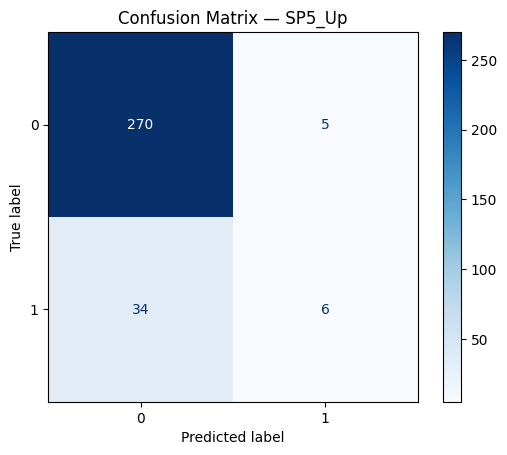

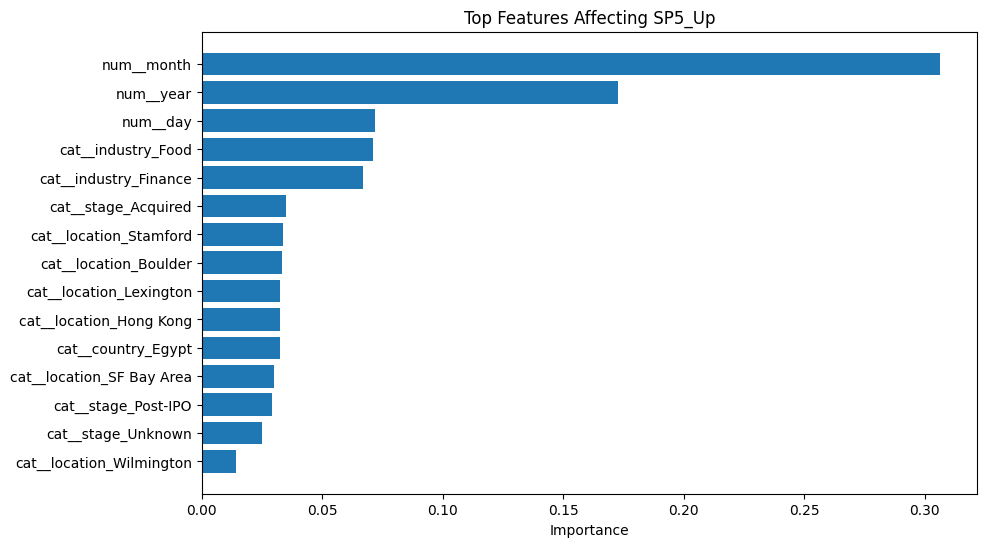

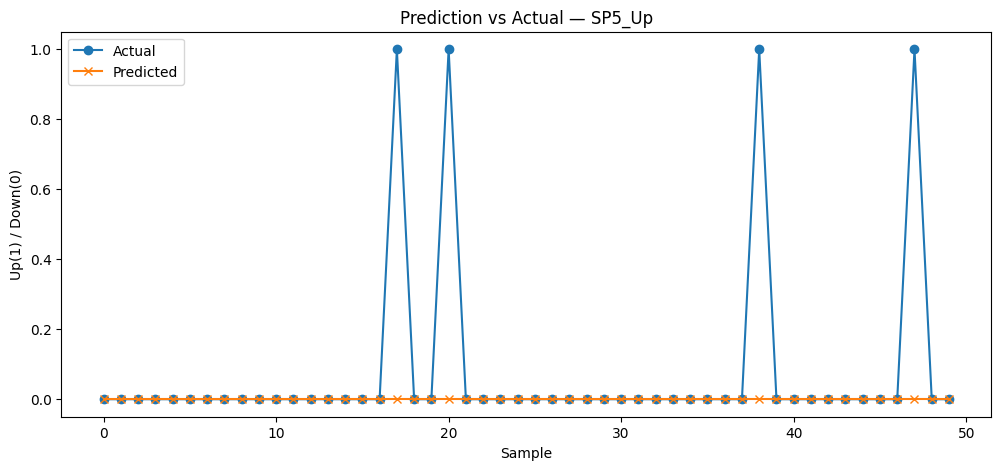

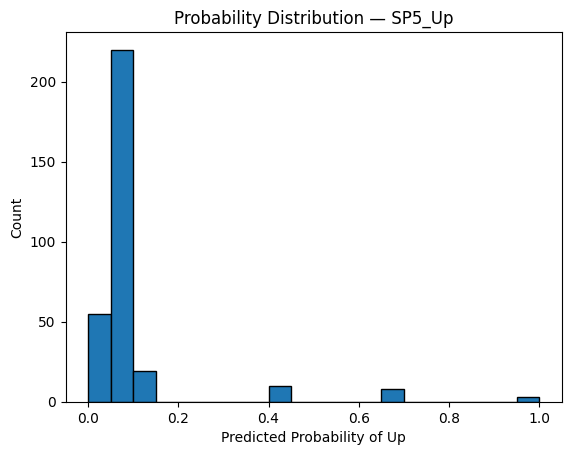


 TRAINING MODEL FOR: DJ_Up

Saving images to: /Users/alice/Desktop/finalproject/model_results/results_DJ_Up
Accuracy for DJ_Up: 0.8698


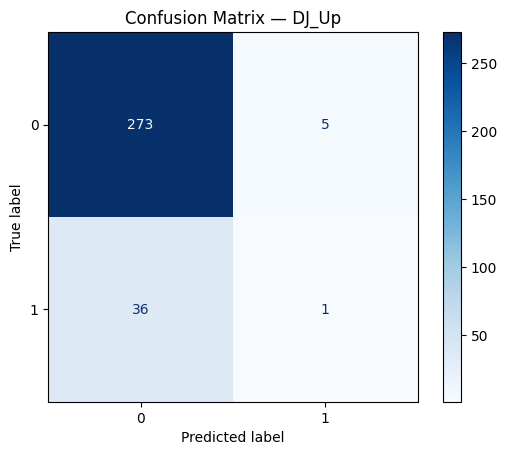

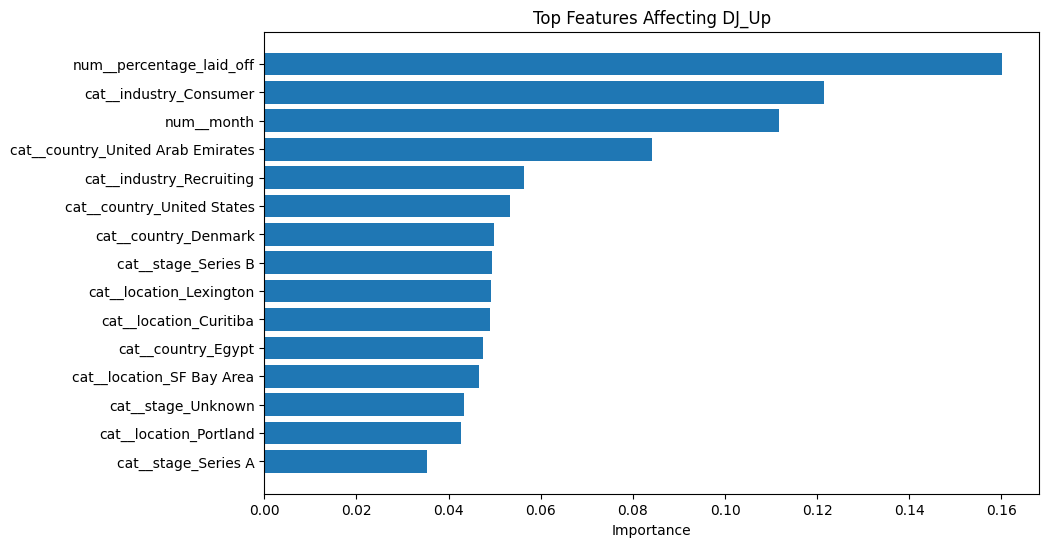

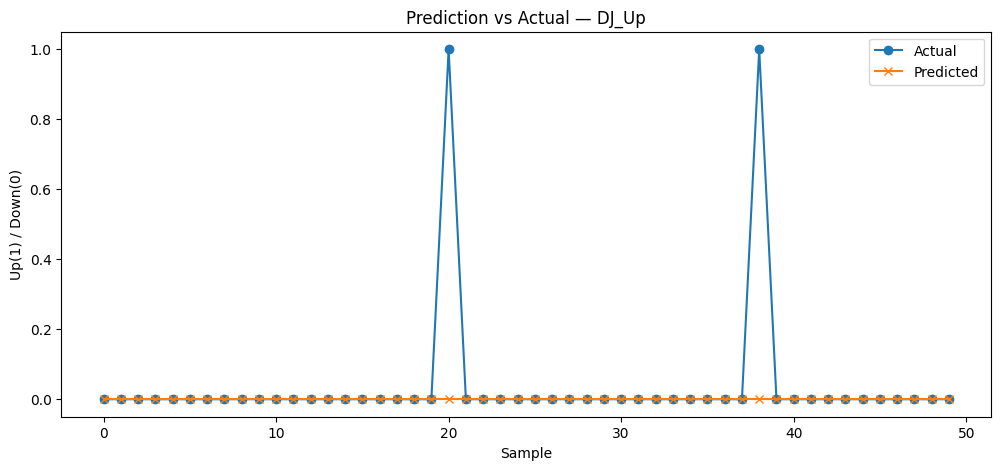

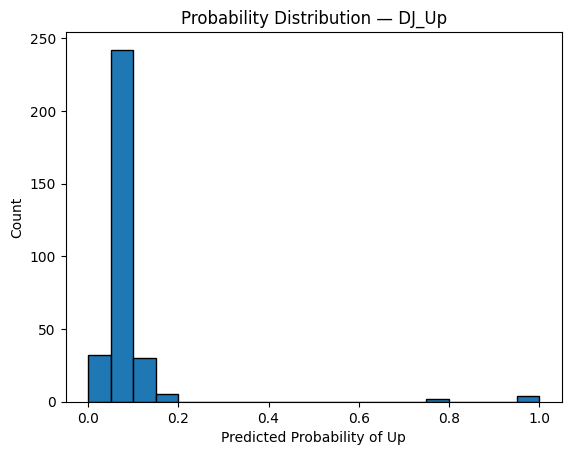


 TRAINING MODEL FOR: VIX_Up

Saving images to: /Users/alice/Desktop/finalproject/model_results/results_VIX_Up
Accuracy for VIX_Up: 0.8889


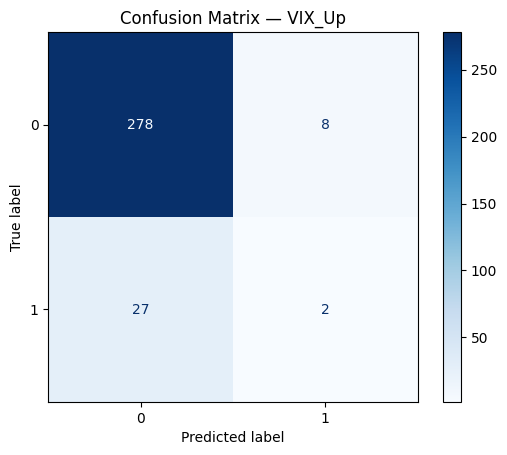

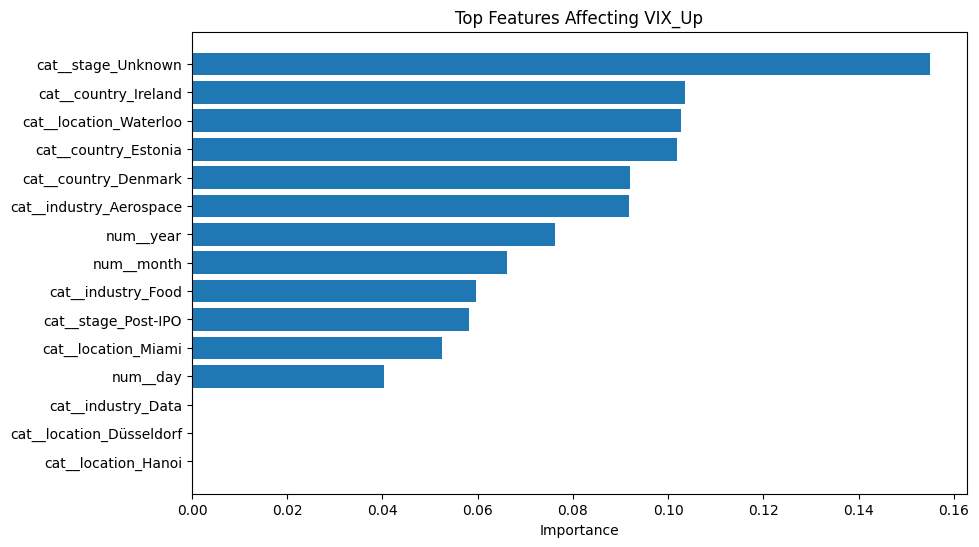

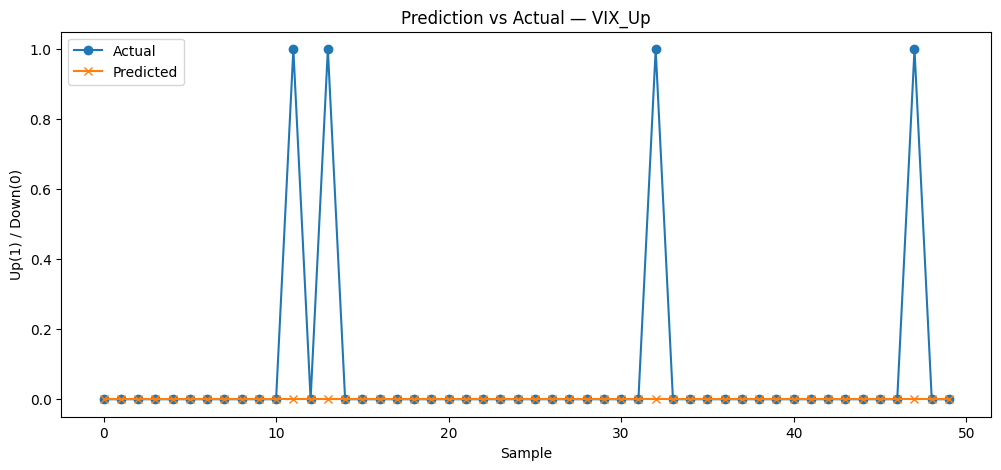

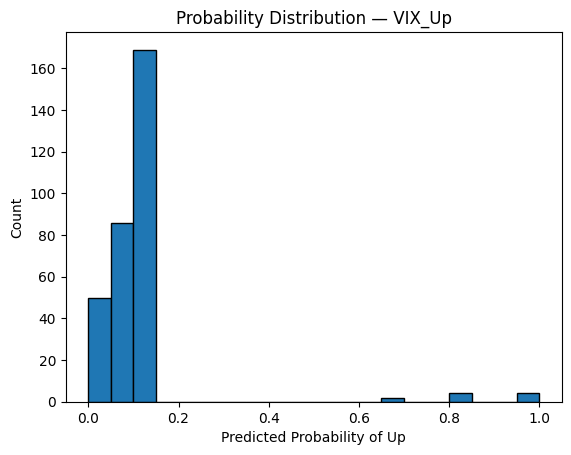

In [11]:
model_SP5 = train_and_plot(df, "SP5_Up")
model_DJ  = train_and_plot(df, "DJ_Up")
model_VIX = train_and_plot(df, "VIX_Up")



 TRAINING MODEL FOR: VIX_Up

Saving images to: /Users/alice/Desktop/finalproject/model_results/results_VIX_Up
Accuracy for VIX_Up: 0.8889


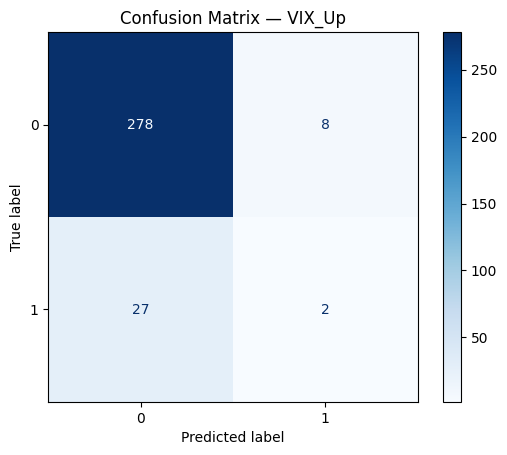

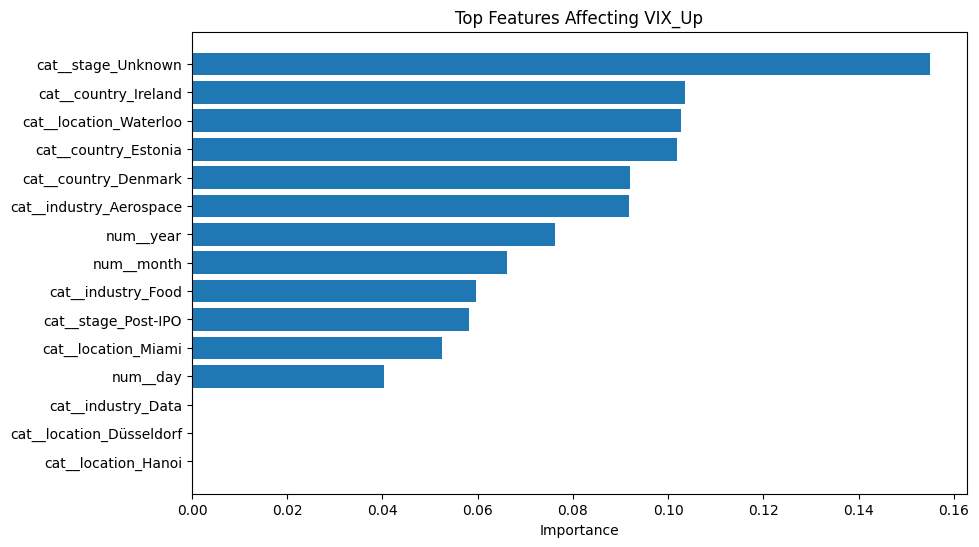

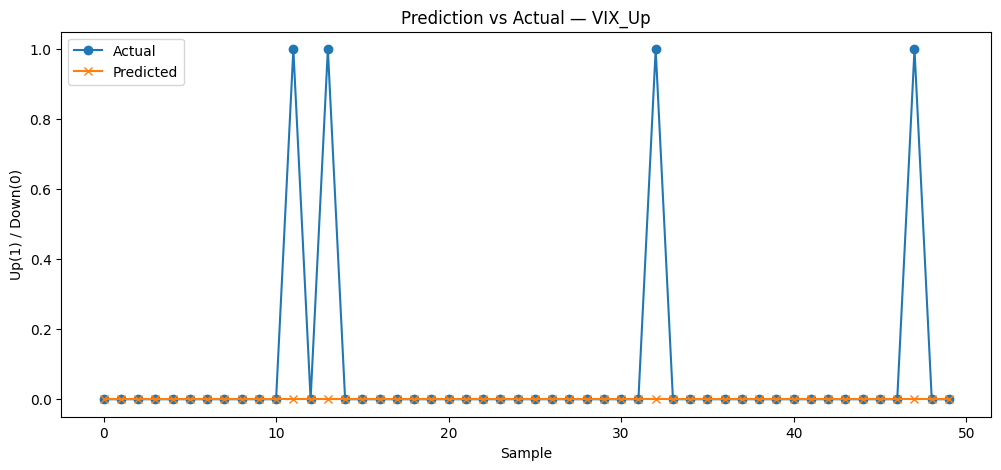

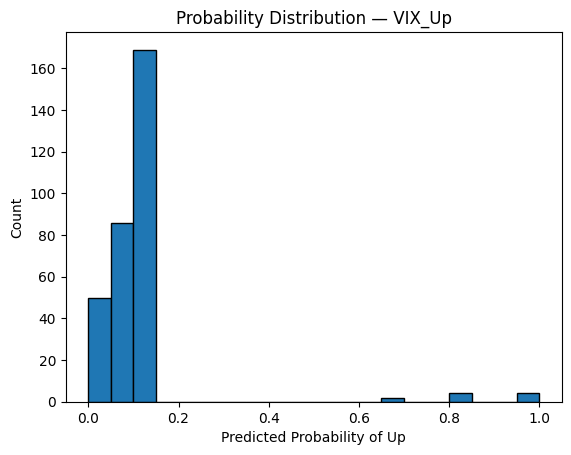

In [13]:
#best model : VIX_Up
model_VIX = train_and_plot(df, "VIX_Up")